# Node Setup

The node which implements the interface is called `jupyter_ui`. 

## Libraries

Here are the needed libraries for the functioning of this Jupyter interface:

In [1]:
# jupyter
import ipywidgets as widgets
import jupyros

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.transforms as mtransforms
from matplotlib.animation import FuncAnimation

# numpy
import numpy as np

# ROS libraries
import rospy
from std_srvs.srv import SetBool, SetBoolRequest, SetBoolResponse
from geometry_msgs.msg import Twist, Pose, Vector3
from nav_msgs.msg import Odometry
from tf.transformations import euler_from_quaternion, quaternion_from_euler
from rt2_assignment1.msg import JupyterTargetInfo

# other python specific
import math

## Node Init

In [2]:
# init
rospy.init_node( "jupyter_ui" )
rospy.on_shutdown( lambda : rospy.loginfo( "jupyter_ui down..." ) )

## Topics and Services

### Behaviour Switch

This service allows the user interface to switch between the so-called "random behaviour" and the manual mode. 

In [3]:
# rospy.wait_for_service( "/ui_trigger" )
ui_mode = rospy.ServiceProxy( "/ui_trigger", SetBool )

By default, the manual mode is set. 

In [4]:
# set by the function
manual_mode = True

# default: manual mode (call the service with True to enable the manual mode)
ui_mode( manual_mode )

success: False
message: ''

### Topic */cmd_vel* 

The Jupyter interface can directly interact with the simulation through the topic `/cmd_vel`. 

First of all, the last command is globally available as the variable `tw`. 

In [5]:
# the last command
tw  = Twist( )

# publisher to /cmd_vel
cmd_vel = rospy.Publisher( "/cmd_vel", Twist, queue_size=1000 )

Publishing on this topic is allowed **only** when the robot is ins manual behaviour. Here is a function to enforce this costraint:

In [6]:
def pub_cmd_vel( stw = Twist( ) ):
    '''publish on /cmd_vel depending on manual_mode
    
    Parameters
    ----------
    stw : geometry_msgs/msg/Twist, optional
        the twist to send through the topic. Default is the zero twist. 
    
    Returns
    -------
    bool
        if the new twist has been sent or not. 
    '''
    
    global cmd_vel, manual_mode
    
    # send only if the manual mode is set
    if manual_mode:
        cmd_vel.publish( stw )
    
    # let's assume that the publisher is always reliable
    return manual_mode

### Subscriber to */odom*

The callback simply takes the message and saves it into a global variable of the program. This particular callback can be extended appending other functions to be executed after the update of the message. 

In [7]:
# the last received odometry (init as empty message)
last_odom_msg = Odometry( )

# other function can be added inside the odometry (with no args)
call_after_save_odom = list( )

# the callback
def save_odometry( msg ):
    '''save the received odometry'''
    
    global last_odom_msg, call_after_save_odom
    last_odom_msg = msg
    
    # execute other callbacks if any
    if len( call_after_save_odom ) > 0 :
        for fnc in call_after_save_odom:
            fnc.__call__( )

# subscription to /odom
rospy.Subscriber( "/odom", Odometry, save_odometry )

### Twist Command from GoToPoint

While the robot is in autonomous mode, the twist comes from the node *GoToPoint.py* and not from this Jupyter Notebook. In order to provide a complete data visualization of real twist Vs. robot command twist, the twist from that node is required. 

**Remark**: when the system is in manual mode, it's assumed that *GoToPoint.py* is in idle state. 

In [8]:
# the last command from GoToPoint 
last_gotopoint_tw = Twist( )

# callback for the subscriber
def save_gotopoint_tw( gotopoint_tw ):
    '''simply save the message in the proper global variable.'''
    
    global last_gotopoint_tw
    last_gotopoint_tw = gotopoint_tw
    
# subscription
rospy.Subscriber( '/current_cmd_vel', Twist, save_gotopoint_tw )

### Status of the node StateMachine

The node *StateMachine.cpp* manages the mission when the robot is set in random behaviour. The message is quite complex, and should be evaluated carefully.

In [9]:
# the last received message from the node
last_statemachine_status = JupyterTargetInfo( )

# in particular (prefix: sm_...)
sm_count_failure = 0
sm_count_success = 0
sm_count_cancel = 0

# it is convenient to add other callbacks after the one of the subscriber
statemachine_exec_after = list( )

# list of targets and time required to reach them
sm_targets_reached = list( )

def add_reached_target( msg ):
    '''add a new reached target'''
    
    global sm_targets_reached
    
    sm_targets_reached.append(
        { 
            "target":( msg.x, msg.y, msg.th ),
            "time":msg.time,
            "new": True
        }
    )

# the base callback
def statemachine_callback( msg ):
    '''interpret the state of the node'''
    
    global last_statemachine_status
    global sm_count_failure, sm_count_success, sm_count_cancel
    global statemachine_exec_after
    
    last_statemachine_status = msg
    
    if msg.working:
        if msg.success:
            # new target reached!
            add_reached_target( last_statemachine_status )
            # count the reached targets
            sm_count_success = sm_count_success + 1
        elif msg.goal_cancelled:
            sm_count_cancel = sm_count_cancel + 1
        elif msg.failure:
            sm_count_failure = sm_count_failure + 1
    
    # execute other callbacks if any
    if len( statemachine_exec_after ) > 0 :
        for fnc in statemachine_exec_after:
            fnc.__call__( )

# subscription
rospy.Subscriber( '/jupyter_mission_info', JupyterTargetInfo, statemachine_callback )

# Widgets

Given that the status of the widgets must be coherent with the behaviour the robot (for instance, the user couldn't be allowed to send commands when the robot is working with the random behaviour). widgets are all defined before defining their callbacks. 

## Status Switch

This ToggleButton simply switches the behaviour of the robot:

- when shaded, the authomatic mode is on
- when light, the robot is waiting for a command from Jupyter.

In [10]:
togglebutton_ui_trigger = widgets.ToggleButton( 
    description = "Random Behaviour",
    value = False,
    disabled = False)

## Sliders

Sliders let the user to directly control the two main velocities of the robot: 

- the linear velocity along the direction in front of the robot
- the angular velocity about the z axis

The sliders are "observed", meaning that each time the user moves one slider, the global twist is observed and sent to the robot.

In [11]:
# for the linear component
slider_linear  = widgets.FloatSlider( min=-1.0, max=1.0, value=0, step=0.1, readout=True )

# for the angular velocity
slider_angular = widgets.FloatSlider( min=-np.pi, max=np.pi, value=0, step=0.1, readout=True )

# useful to stop the robot
button_set_zero = widgets.Button( value=False, description="set zero" )

## Control Pad

Here is the CSS used to set the graphical aspect of the pad. Flex is applied here:

In [12]:
lay_item = widgets.Layout( 
    display="auto" )

lay_vitem = widgets.Layout( 
    display="auto", 
    align_self="center" )

lay_stop_button = widgets.Layout( 
    display="auto", 
    align_self="center", 
    width="75%", 
    margin="0" )

lay_auto_vcenter = widgets.Layout( 
    display="auto",
    position="absolute",
    top="50%" )

lay_vertical = widgets.Layout(
    display="flex", 
    flex_flow="column",
    align_items="stretch",
    justify_content="center" )

lay_horizontal = widgets.Layout(
    display="flex",
    flex_direction="column",
    justify_content="center",
    align_items="baseline" )

And here is the pad for manually controlling the robot. 

In [13]:
# labels showing the velocities, over the pad
txt_front = widgets.Label( value="front: 0.00m/s", layout=lay_vitem )
txt_left = widgets.Label( value="left: 0.00m/s", layout=lay_vitem )
txt_rot = widgets.Label( value="rotation: 0.00rad/s", layout=lay_vitem )

# keys of the pad
b_up = widgets.Button( description="^", layout=lay_item )
b_down = widgets.Button( description="v", layout=lay_item )
b_left = widgets.Button( description="<", layout=lay_vitem )
b_right = widgets.Button( description=">", layout=lay_vitem )
b_stop = widgets.Button( description="STOP", layout=lay_stop_button)

# layout organization --- text
txt_box = widgets.Box( [txt_front, txt_left, txt_rot], layout=lay_horizontal )

# layout organization --- pad
vertical_buttons = widgets.Box( [b_up, b_down], layout=lay_vertical )
cmd_pad = widgets.Box( [b_left, vertical_buttons, b_right], layout=lay_horizontal )
complete_pad = widgets.Box( [txt_box, cmd_pad, b_stop], layout=lay_vertical )

# Callbacks

## Status Switch

in addition to switch between the two behaviours, the button must disable and reset the status of the other widgets for the manual control. 

In [14]:
# list of widgets to enable/disable each time the state change
manual_mode_widgets = [
    slider_linear, slider_angular, button_set_zero,
    b_up, b_down, b_left, b_right, b_stop
]

def change_ui_status( val ):
    '''switch between the two behaviours: random, or manual'''
    
    global manual_mode
    global manual_mode_widgets
    global slider_linear, slider_angular
    
    manual_mode = not manual_mode
    ui_mode( manual_mode )
    
    # if manual mode is set, enable all the widgets
    for wg in manual_mode_widgets:
        wg.disabled = not manual_mode
    
    # if the authomatic mode is set, clear the sliders
    if not manual_mode:
        slider_linear.value = 0.0
        slider_angular.value = 0.0
        
        # the last twist becomes zero
        tw = Twist( )
        pub_cmd_vel( tw )

# register the widget
togglebutton_ui_trigger.observe( change_ui_status, names='value' )

## Sliders

In [15]:
def on_linear_change( slider_v ):
    '''update and send the linear velocity along x'''
    
    global tw
    
    tw.linear.x = slider_v['new']
    pub_cmd_vel( tw )

def on_angular_change( slider_a ):
    '''update and send the angular velocity about z'''
    
    global tw
    
    tw.angular.z = slider_a['new']
    pub_cmd_vel( tw )
    
def slider_set_zero( bclick ):
    '''set zero to both the sliders and stop the robot'''
    
    global slider_linear, slider_angular, tw
    
    slider_linear.value  = 0.0
    slider_angular.value = 0.0
    
    # set zero velocity
    tw = Twist( )
    
    pub_cmd_vel( tw )
    
# observe the values of the sliders and the button
slider_linear.observe( on_linear_change, names="value" )
slider_angular.observe( on_angular_change, names="value" )
button_set_zero.on_click( slider_set_zero )

## Control Pad

Labels must be updated. It is sufficient to add a function ot be executed after the odometry callback

In [16]:
def update_vel_txt( ):
    '''update the label widgets whowing the velocity'''
    
    global last_odom_msg, txt_front, txt_left, txt_rot
    
    msg = last_odom_msg
    txt_front.value = ("front: {:.2f}m/s").format( msg.twist.twist.linear.x )
    txt_left.value = ("left: {:.2f}m/s").format( msg.twist.twist.linear.y )
    txt_rot.value = ("rotation: {:.2f}rad/s").format( msg.twist.twist.angular.z )
    
# add the function to the list of callbacks to execute after the main one
call_after_save_odom.append( update_vel_txt )

The pad requires some other functions to work. When one button is clicked, the correponding component of the twist is incremented by a fixed step. 

In [17]:
# used to update the velocity
linear_step = 0.5
angular_step = 0.25

# common part of the functions below
def update_vel( ):
    global tw
    pub_cmd_vel( tw )

# pad keys callbacks
def stop_all( b ):
    global tw
    tw = Twist( )
    update_vel( )

def up( b ):
    global tw, linear_step
    tw.linear.x = tw.linear.x + linear_step
    update_vel( )

def down( b ):
    global tw, linear_step
    tw.linear.x = tw.linear.x - linear_step
    update_vel( )

def left( b ):
    global tw, angular_step
    tw.angular.z = tw.angular.z - angular_step
    update_vel( )

def right( b ):
    global tw, angular_step
    tw.angular.z = tw.angular.z + angular_step
    update_vel( )

# callbacks setup
b_up.on_click( up )
b_down.on_click( down )
b_left.on_click( left )
b_right.on_click( right )
b_stop.on_click( stop_all )

# The interface

In [18]:
%matplotlib notebook

## Position and orientation of the robot across the map

An arrow shows the orientation of the robot. The representation is built as animation in MatPlotLib. 

Label(value='---')

<IPython.core.display.Javascript object>


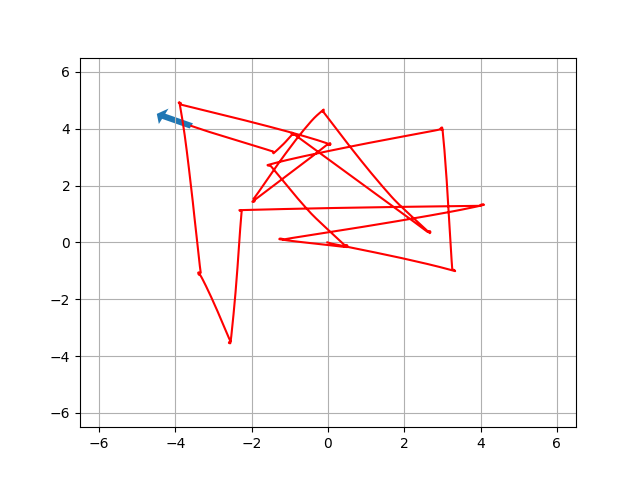

In [19]:
wtext = widgets.Label( value="---" )
display( wtext )
fig, ax = plt.subplots( )

x = []
y = []

area = 6.5
trajectory, = ax.plot( x, y, '-r' )
arrow_pos = patch.Arrow( 0, 0, 1, 0 )
ax.set_xlim( -area, area )
ax.set_ylim( -area, area )
ax.grid( True )

def update_position( frame ):
    '''read the last odometry and update the data inside the plot'''
    
    global x, y, trajectory, last_odom_msg, ax, arrow_pos, wtext
    
    tw = last_odom_msg.twist.twist
    pos = last_odom_msg.pose.pose.position
    qrot = last_odom_msg.pose.pose.orientation
    rot = euler_from_quaternion( [ qrot.x, qrot.y, qrot.z, qrot.w ] )[2]
    
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    trot = mtransforms.Affine2D.from_values( np.cos( rot ), np.sin( rot ), -np.sin( rot ), np.cos( rot ), pos.x, pos.y )
    arrow_pos._patch_transform = trot.frozen( )
    
    wtext.value = f"pos({pos.x:.2f}m, {pos.y:.2f}m) th({rot:.2f}rad) -- twist({tw.linear.x:.2f}m/s, {tw.linear.y:.2f}m/s, {tw.angular.z:.2f}rad/s)"
    
    return (trajectory, arrow_pos)

def init_animation( ):
    '''init the plot, showing the first position and orientation'''
    
    global x, y, trajectory, ax, arrow_pos
    
    pos = last_odom_msg.pose.pose.position
    qrot = last_odom_msg.pose.pose.orientation
    rot = euler_from_quaternion( [ qrot.x, qrot.y, qrot.z, qrot.w ] )[2]
    
    x.append( pos.x )
    y.append( pos.y )
    trajectory.set_data( x, y )
    
    trot = mtransforms.Affine2D.from_values( np.cos( rot ), np.sin( rot ), -np.sin( rot ), np.cos( rot ), pos.x, pos.y )
    arrow_pos._patch_transform = trot.frozen( )
    ax.add_patch( arrow_pos )
    
    return (trajectory, arrow_pos)

anim = mpl.animation.FuncAnimation( 
    fig, update_position, interval=125, blit=True, save_count = True, init_func=init_animation )

## Behaviour toggle

In [20]:
display( togglebutton_ui_trigger )

ToggleButton(value=False, description='Random Behaviour')

## Sliders

In [21]:
display( slider_linear, slider_angular, button_set_zero )

FloatSlider(value=0.0, max=1.0, min=-1.0)

FloatSlider(value=0.0, max=3.141592653589793, min=-3.141592653589793)

Button(description='set zero', style=ButtonStyle())

## Control Pad

In [22]:
display( complete_pad )

Box(children=(Box(children=(Label(value='front: -0.00m/s', layout=Layout(align_self='center', display='auto'))…

# Data Visualization

## Actual Velocity Vs. Command Velocity

Two plots: the first plots the real linear velocity compared to the command given the robot, and the second one shows the angular velocity in the same way. 

Before presenting the code, the system needs a callback to properly set *tw* when the robot is in random behaviour. The callback is appended to the execution of the other callback *statemachine_callback*. 

In [23]:
# the callback, to append to statemachine_callback
def random_behaviour_update_tw( ):
    '''update tw with the one sent by the node GoToPoint.py'''
    
    global manual_mode, tw, last_statemachine_status, last_gotopoint_tw
    
    if (not manual_mode) and ( last_statemachine_status.working ):
        tw = last_gotopoint_tw

# append the callback
statemachine_exec_after.append( random_behaviour_update_tw )

Here the code of the graph:

<IPython.core.display.Javascript object>


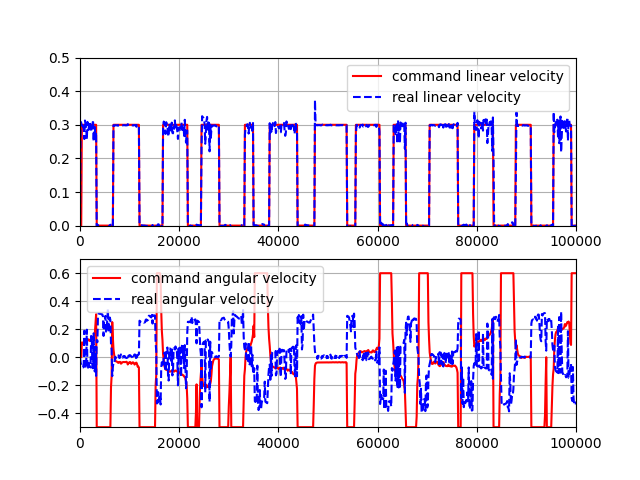

In [24]:
# subplots
vcompared_fig, vcompared_ax = plt.subplots( nrows=2 )

# time axis
t = 0
t_list = list( )
t_step = 125

# first subplot: command linear Vs real linear velocity
tw_linear_cmd = list( )
tw_linear_real = list( )
plt_tw_linear_cmd, = vcompared_ax[0].plot( t_list, tw_linear_cmd, '-r', label="command linear velocity" ) 
plt_tw_linear_real, = vcompared_ax[0].plot( t_list, tw_linear_real, '--b', label="real linear velocity" ) 

# second subplot: command Vs real angular velocity
tw_angular_cmd = list( )
tw_angular_real = list( )
plt_tw_angular_cmd, = vcompared_ax[1].plot( t_list, tw_angular_cmd, '-r', label="command angular velocity" ) 
plt_tw_angular_real, = vcompared_ax[1].plot( t_list, tw_angular_real, '--b', label="real angular velocity" )

vcompared_ax[0].set_xlim(0, 100000)
vcompared_ax[0].set_ylim(0, 0.5)
vcompared_ax[0].grid( True )
vcompared_ax[0].legend( )
vcompared_ax[1].set_xlim(0, 100000)
vcompared_ax[1].set_ylim(-0.5, 0.7)
vcompared_ax[1].grid( True )
vcompared_ax[1].legend( )


# the main function for the animation here
def vcompared_update( frame ):
    global tw, last_odom_msg
    global t, t_list, t_step
    global tw_linear_cmd, tw_linear_real, tw_angular_cmd, tw_angular_real
    global plt_tw_linear_cmd, plt_tw_linear_real, plt_tw_angular_cmd, plt_tw_angular_real
    
    # increment time axis
    t_list.append( t )
    t = t + t_step
    
    # retrieve new data for the plots
    tw_linear_cmd.append( tw.linear.x )
    tw_angular_cmd.append( tw.angular.z )
    tw_linear_real.append( last_odom_msg.twist.twist.linear.x )
    tw_angular_real.append( last_odom_msg.twist.twist.angular.z )
    
    # and set the data
    plt_tw_linear_cmd.set_data( t_list, tw_linear_cmd )
    plt_tw_linear_real.set_data( t_list, tw_linear_real )
    plt_tw_angular_cmd.set_data( t_list, tw_angular_cmd )
    plt_tw_angular_real.set_data( t_list, tw_angular_real )
    
    return ( plt_tw_linear_cmd, plt_tw_linear_real, plt_tw_angular_cmd, plt_tw_angular_real )

# animation object
vcomared_anim = FuncAnimation( vcompared_fig, vcompared_update, interval=t_step, blit=True )

## Histogram -- Counters and Mission Time plots

Two plots. The one on the left represents how many targets has been reached, cancelled, or simply failed (always out of time in this implementation). And the one on the right shows how much time one succeded target required. 

**Le animazioni dei bar plot non si fanno in maniera normale (e quando mai?). Vedi [qui](https://stackoverflow.com/questions/42056347/animated-barplot-in-python) in particolare la funzione _set_heigth()_**

<IPython.core.display.Javascript object>


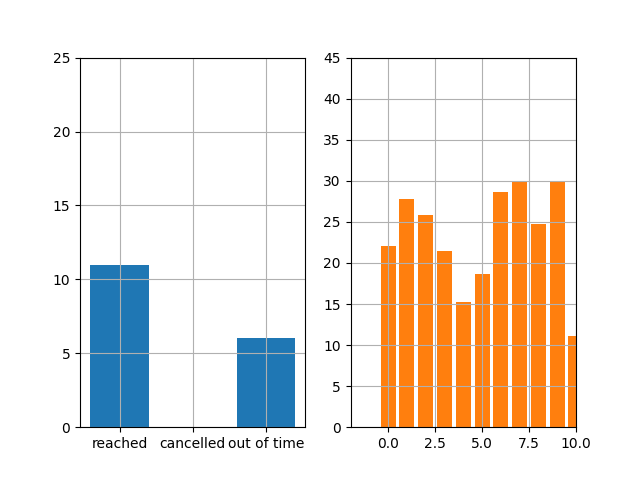

In [25]:
# two plots
goals_fig, goals_ax = plt.subplots( ncols = 2 )

# jupy label over the figure representing the stats of the current mission
# TODO

# append a function to update the text 
def update_mission_stats( ):
    pass

statemachine_exec_after.append( update_mission_stats )

# first column -- histogram
goals_bar = goals_ax[0].bar( 
    ['reached', 'cancelled', 'out of time'], [sm_count_success, sm_count_cancel, sm_count_failure])
goals_ax[0].grid( True )
goals_ax[0].set_ylim(0, 25)

# second column -- goal and time
goals_reached_plot = goals_ax[1].bar( [], [] )
goals_ax[1].grid( True )
goals_ax[1].set_xlim(-2, 10)
goals_ax[1].set_ylim(0, 45)

# update the graph when the values change
def goals_update( frame ):
    global goals_bar, goals_reached_plot, goals_ax
    global sm_success, sm_cancel, sm_failure, sm_targets_reached
    
    # update the first graph
    # NON FUNZIONA
    '''
    goals_bar.set_data( 
        ['reached', 'cancelled', 'out of time'], [sm_count_success, sm_count_cancel, sm_count_failure])
    '''
    goals_bar[0].set_height( sm_count_success )
    goals_bar[1].set_height( sm_count_cancel )
    goals_bar[2].set_height( sm_count_failure )
    
    # update the second graph
    # NON FUNZIONA
    '''
    goals_reached_plot = goals_ax[1].bar(
        np.arange( 1, len( sm_targets_reached ), 1 ), 
        [ tg["time"] for tg in sm_targets_reached ]
    )
    '''
    for tg in sm_targets_reached:
        if tg["new"]:
            goals_reached_plot.remove( )
            goals_reached_plot = goals_ax[1].bar(
                np.arange( 0, len( sm_targets_reached ), 1 ), 
                [ tg["time"] for tg in sm_targets_reached ]
            )
            tg["new"] = False
    
    return tuple( [ x for x in goals_reached_plot ] + [ x for x in goals_reached_plot ] )

# setup the animation (very low update rate)
goals_update_rate = 750 # ms 
goals_anim = FuncAnimation( goals_fig, goals_update, interval = goals_update_rate, blit=True )

# Da fare

- adattare le larghezze e lunghezze degli assi dei grafici in modo da adattarsi ad eventuali picchi. 
- grafico velocità: implementa una sorta di scorrimento dei dati
- grafico velocità: perchè la velocità angolare da comando è sempre invertita rispetto a quella reale? C'è magari qualche errore nell'implementazione del topic in GoToPoint.py?
- plot tempo di missione: aggiungere qualcosa che indichi sia il tempo limite (fatti passare il tempo limite dal nodo stateMachine.cpp) e il tempo impiegato. Potresti usare Tick oppure una label sopra alla barra
- plot count missione: aggiungi il valore della barra sopra la barra
- aggiusta le frequenze di funzionamento per alleggerire l'interfaccia. In particolare, definisci delle frequenze a livello globale
- riesci a dividere questo documento Jupyter in due o più documenti, uno con l'interfaccia e l'altro con le visuals?
- ultimo bar plot: il colore delle bars dev'essere sempre lo stesso, non dovrebbe cambiare ogni volta che il plot viene aggiornato
- riesci ad aggiungere la visualizzazione in JupyRos del robot in un altro documento? 
- aggiungere un'opzione che permette di interrompere una missione una volta portata a termine, un semplice switch (oppure un altro toggleButton?)
- aggiusta i tick dei vari grafici
- time plot: aggiungi gli aggiornamenti sul tempo di missione come label al di sopra dei due plot, vedi 